In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import os
import time
from unidecode import unidecode
import warnings
from mplsoccer.pitch import Pitch
import seaborn as sns

In [71]:
match_html_path = r"C:\Users\K Raghunandan\Analyst\Matches\Barcelona-Paris Saint-Germain - Champions League 2025_2026 Live.html"
fotmob_matchId = 4947145

def extract_json_from_html(html_path, save_output=False):
    with open(html_path, 'r', encoding='utf-8') as html_file:
        html = html_file.read()

    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for JSON parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save JSON data to txt
        output_file = open(f"{html_path}.txt", "wt", encoding='utf-8')
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

def get_short_name(full_name):
    if pd.isna(full_name):
        return full_name
    parts = full_name.split()
    if len(parts) == 1:
        return full_name  # No need for short name if there's only one word
    elif len(parts) == 2:
        return parts[0][0] + ". " + parts[1]
    else:
        return parts[0][0] + ". " + parts[1][0] + ". " + " ".join(parts[2:])

json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

df = pd.DataFrame(events_dict)
dfp = pd.DataFrame(players_df)
dfp['shortName'] = dfp['name'].apply(get_short_name)

In [72]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'goalMouthZ', 'goalMouthY', 'isShot', 'isGoal', 'cardType'],
      dtype='object')

In [73]:
dfp.columns

Index(['playerId', 'shirtNo', 'name', 'position', 'height', 'weight', 'age',
       'isFirstEleven', 'isManOfTheMatch', 'field', 'stats',
       'subbedInPlayerId', 'subbedOutPeriod', 'subbedOutExpandedMinute',
       'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId',
       'teamId', 'shortName'],
      dtype='object')

In [74]:
df['type'] = df['type'].str.extract(r"'displayName': '([^']+)")
df['outcomeType'] = df['outcomeType'].str.extract(r"'displayName': '([^']+)")
df['period'] = df['period'].str.extract(r"'displayName': '([^']+)")

In [75]:
df['teamName'] = df['teamId'].map(teams_dict)
team_names = list(teams_dict.values())
opposition_dict = {team_names[i]: team_names[1-i] for i in range(len(team_names))}
df['oppositionTeamName'] = df['teamName'].map(opposition_dict)

In [76]:
df['x'] = df['x']*1.2
df['y'] = df['y']*0.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*0.8
df['goalMouthY'] = df['goalMouthY']*0.8

In [77]:
columns_to_drop = ['height', 'weight', 'age', 'isManOfTheMatch', 'field', 'stats', 
                   'subbedInPlayerId', 'subbedOutPeriod', 
                   'subbedOutExpandedMinute', 'subbedInPeriod', 'subbedInExpandedMinute', 'subbedOutPlayerId', 
                   'teamId']
dfp.drop(columns=columns_to_drop, inplace=True)

In [78]:
df = df.merge(dfp, on='playerId', how='left')

In [79]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'relatedEventId', 'relatedPlayerId', 'blockedX', 'blockedY',
       'goalMouthZ', 'goalMouthY', 'isShot', 'isGoal', 'cardType', 'teamName',
       'oppositionTeamName', 'shirtNo', 'name', 'position', 'isFirstEleven',
       'shortName'],
      dtype='object')

In [80]:
df

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,...,isShot,isGoal,cardType,teamName,oppositionTeamName,shirtNo,name,position,isFirstEleven,shortName
0,2.854365e+09,2,0,0.0,304,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,PSG,Barcelona,NaN,NaN,NaN,NaN,NaN
1,2.854365e+09,2,0,0.0,65,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Barcelona,PSG,NaN,NaN,NaN,NaN,NaN
2,2.854365e+09,3,0,0.0,304,60.00,40.08,0,NaN,NaN,...,NaN,NaN,NaN,PSG,Barcelona,8.0,Fabián Ruiz,MC,True,F. Ruiz
3,2.854365e+09,4,0,18.0,65,41.16,80.00,0,NaN,NaN,...,NaN,NaN,NaN,Barcelona,PSG,18.0,Gerard Martín,DL,True,G. Martín
4,2.854365e+09,5,0,19.0,304,75.24,8.64,0,NaN,NaN,...,NaN,NaN,NaN,PSG,Barcelona,8.0,Fabián Ruiz,MC,True,F. Ruiz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,2.854438e+09,847,94,0.0,304,0.00,0.00,97,NaN,NaN,...,NaN,NaN,NaN,PSG,Barcelona,NaN,NaN,NaN,NaN,NaN
1502,2.854438e+09,797,0,0.0,65,0.00,0.00,7,NaN,NaN,...,NaN,NaN,NaN,Barcelona,PSG,NaN,NaN,NaN,NaN,NaN
1503,2.854438e+09,848,0,0.0,304,0.00,0.00,7,NaN,NaN,...,NaN,NaN,NaN,PSG,Barcelona,NaN,NaN,NaN,NaN,NaN
1504,2.854333e+09,1,0,0.0,65,0.00,0.00,0,NaN,NaN,...,NaN,NaN,NaN,Barcelona,PSG,NaN,NaN,NaN,NaN,NaN


In [81]:
dfp

,playerId,shirtNo,name,position,isFirstEleven,shortName
0,73379,25,Wojciech Szczesny,GK,True,W. Szczesny
1,301019,23,Jules Koundé,DR,True,J. Koundé
2,368091,24,Eric García,DC,True,E. García
3,498386,5,Pau Cubarsí,DC,True,P. Cubarsí
4,512879,18,Gerard Martín,DL,True,G. Martín
5,279423,21,Frenkie de Jong,DMC,True,F. d. Jong
6,402197,8,Pedri,DMC,True,Pedri
7,480249,10,Lamine Yamal,AMR,True,L. Yamal
8,261212,20,Dani Olmo,AMC,True,D. Olmo
9,300299,14,Marcus Rashford,AML,True,M. Rashford


In [82]:
df=df[["minute","second","x","y","endX","endY","teamName","shirtNo","position","shortName","goalMouthY","isShot","isGoal"]]

In [83]:
df

,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,0,0.0,0.00,0.00,NaN,NaN,PSG,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.0,0.00,0.00,NaN,NaN,Barcelona,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0.0,60.00,40.08,95.16,0.00,PSG,8.0,MC,F. Ruiz,NaN,NaN,NaN
3,0,18.0,41.16,80.00,47.16,71.92,Barcelona,18.0,DL,G. Martín,NaN,NaN,NaN
4,0,19.0,75.24,8.64,86.64,21.52,PSG,8.0,MC,F. Ruiz,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,94,0.0,0.00,0.00,NaN,NaN,PSG,NaN,NaN,NaN,NaN,NaN,NaN
1502,0,0.0,0.00,0.00,NaN,NaN,Barcelona,NaN,NaN,NaN,NaN,NaN,NaN
1503,0,0.0,0.00,0.00,NaN,NaN,PSG,NaN,NaN,NaN,NaN,NaN,NaN
1504,0,0.0,0.00,0.00,NaN,NaN,Barcelona,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
df = df[
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['endX'].notna()) & 
    (df['endY'].notna())) | 
    ((df['x'].notna()) & 
    (df['y'].notna()) & 
    (df['goalMouthY'].notna()))
]

In [85]:
df=df.reset_index()

In [86]:
df

,index,minute,second,x,y,endX,endY,teamName,shirtNo,position,shortName,goalMouthY,isShot,isGoal
0,2,0,0.0,60.00,40.08,95.16,0.00,PSG,8.0,MC,F. Ruiz,NaN,NaN,NaN
1,3,0,18.0,41.16,80.00,47.16,71.92,Barcelona,18.0,DL,G. Martín,NaN,NaN,NaN
2,4,0,19.0,75.24,8.64,86.64,21.52,PSG,8.0,MC,F. Ruiz,NaN,NaN,NaN
3,5,0,21.0,39.24,60.32,38.28,60.24,Barcelona,24.0,DC,E. García,NaN,NaN,NaN
4,7,0,24.0,74.04,22.24,78.84,22.48,PSG,17.0,MC,Vitinha,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,1495,93,43.0,46.92,69.44,69.60,75.60,PSG,21.0,Sub,L. Hernández,NaN,NaN,NaN
1008,1496,93,49.0,61.92,75.68,41.52,76.80,PSG,47.0,Sub,Q. Ndjantou,NaN,NaN,NaN
1009,1497,93,51.0,34.44,74.40,10.32,52.48,PSG,21.0,Sub,L. Hernández,NaN,NaN,NaN
1010,1498,93,55.0,10.08,48.72,5.40,23.36,PSG,30.0,GK,L. Chevalier,NaN,NaN,NaN


In [87]:
df.to_csv("basjdb.csv",index=False)

C:\Users\K Raghunandan\AppData\Local\Temp\ipykernel_6504\3388873781.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde=sns.kdeplot(


Text(0.5, 1.0, 'Achraf Hakimi Passmap vs FC Barcelona')

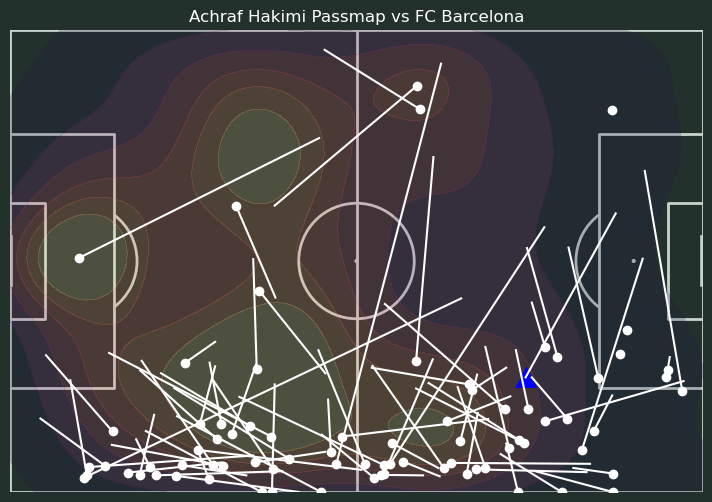

In [118]:
fig, ax= plt.subplots(figsize=(10.5,6))
fig.set_facecolor("#22312b")
ax.patch.set_facecolor("#22312b")

pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
pitch.draw(ax=ax, constrained_layout=True, tight_layout=False)
plt.gca().invert_yaxis()

plt.xlim(0,120)
plt.ylim(0,80)

kde=sns.kdeplot(
    data=df, x="x", y="y",
    shade=True,
    shade_lowest=False,
    alpha=.2,
    bw_adjust=1,
    n_levels=7,
    cmap="magma"
)

for x in range(len(df["x"])):
    if df["shortName"][x]=="A. Hakimi":
        plt.plot((df["x"][x],df["endX"][x]),(df["y"][x],df["endY"][x]),color="white")
        plt.scatter(df["x"][x],df["y"][x],color="white")
        
plt.scatter(df["x"][973],df["y"][973],color="blue",marker="^",s=200)

plt.title("Achraf Hakimi Passmap vs FC Barcelona", color="white")

In [26]:
df.shortName.unique()

array(['F. Ruiz', 'G. Martín', 'E. García', 'Vitinha', 'S. Mayulu',
       'N. Mendes', 'W. Pacho', 'L. Chevalier', 'I. Zabarnyi',
       'A. Hakimi', 'W. Zaïre-Emery', 'I. Mbaye', 'F. d. Jong',
       'W. Szczesny', 'J. Koundé', 'L. Yamal', 'P. Cubarsí',
       'M. Rashford', 'Pedri', 'F. Torres', 'D. Olmo', 'B. Barcola',
       'L. Hernández', 'M. Casadó', 'A. Balde', 'R. Lewandowski',
       'G. Ramos', 'L. Kang-In', 'Q. Ndjantou', 'M. Bernal',
       'A. Christensen'], dtype=object)